In [9]:
import numpy as np
from pysr import PySRRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from data_preprocessing import data_preprocess
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
pd.set_option('display.max_colwidth', None)
from sympy import sympify
import seaborn as sns
import os
import warnings
from matplotlib.patches import Patch
warnings.filterwarnings("ignore")

In [13]:
plt.rcParams.update({
    'font.size': 14,           # Global font size for all text
    'font.family': 'DejaVu Sans', # Global font family
    'font.sans-serif': ['DejaVu Sans'],  # Preferred sans-serif font
    'axes.titlesize': 16,      # Font size for titles
    'axes.labelsize': 14,      # Font size for axis labels
    'xtick.labelsize': 12,     # Font size for x-axis tick labels
    'ytick.labelsize': 12,     # Font size for y-axis tick labels
    'legend.fontsize': 12,     # Font size for legends
    'figure.titlesize': 16,    # Font size for figure title
})

In [39]:
def r2_calc(y, y_pred):
    r2 =r2_score(y, y_pred)
    return r2, y, y_pred

def mse_calc(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    return mse

def error_percentage(y, y_pred):
    percentage = np.abs((y - y_pred) / y) * 100
    # delete inf values in percentage
    percentage = percentage[percentage != np.inf]
    error = np.mean(percentage)
    return error

# detect outliers using 3 standard deviation
def detect_outliers(data, threshold=3):
    mean = np.mean(data['delta_phi'])
    std_dev = np.std(data['delta_phi'])
    outliers = []
    for i in data['delta_phi']:
        z_score = (i - mean) / std_dev
        if np.abs(z_score) > threshold:
            outliers.append(i)
    data_without_outliers = data[~data['delta_phi'].isin(outliers)]
    return data_without_outliers

'''def y_calculation(model, origin_data):
    equation = model.sympy()
    # symbols is the column names of the origin data, except the target column:delta_phi
    symbols = sp.symbols(origin_data.columns[:-1])
    equation_func = sp.lambdify(symbols, equation, "numpy")
    y = equation_func(*[origin_data[col] for col in origin_data.columns[:-1]])
    return y, equation'''
    
import sympy as sp
import numpy as np

def y_calculation(model, origin_data):
    equation = model.sympy()
    column_names = origin_data.columns[:-1]
    symbols = sp.symbols(column_names)
    if 'density' in origin_data.columns:
        density = sp.Symbol('density')  # Create a symbol for 'density'
    else:
        raise ValueError("Density column is missing in the input data.")
    density_term = density / (10**(-16) + density**1.005)
    modified_equation = equation * density_term
    equation_func = sp.lambdify(symbols, modified_equation, "numpy")
    inputs = [origin_data[col].values for col in column_names]
    y = equation_func(*inputs)
    return y, modified_equation


def regression_plot(y_origin, y_pred):
    plt.scatter(y_origin, y_pred, color='#955251')
    plt.ylabel('Predicted Value')
    plt.xlabel('True Value')
    r2 = r2_score(y_origin, y_pred)
    MAPE = error_percentage(y_origin, y_pred)
    #plt.text(0.1, 0.9, f'$R^2$ = {r2:.2f}', transform=plt.gca().transAxes)
    #plt.text(0.1, 0.8, f'MAPE = {MAPE:.2f}%', transform=plt.gca().transAxes)
    plt.ylim(-2,3)
    plt.plot(y_origin, y_origin, color='slategray', linestyle='--')
    
def plot_predict(model, data):
    X = data.drop('delta_phi', axis=1)
    y = model.predict(X)
    #y, equation = y_calculation(model, data)
    plt.figure(figsize=(14, 16))
    plt.subplot(4, 3, 1)
    regression_plot(data['delta_phi'], y)

    plt.subplot(4, 3, 2)
    ymax = max(y.max(), data['delta_phi'].max()) + 0.05
    ymin = min(y.min(), data['delta_phi'].min()) - 0.05
    scatter = plt.scatter(data['density'], data['delta_phi'], c=data['temperature'], cmap='viridis')
    color_bar = plt.colorbar(scatter)
    plt.xlabel('Density')
    #plt.ylim(ymin, ymax)
    plt.ylim(-2,3)
    plt.ylabel('$\\Delta \\phi$')

    plt.subplot(4, 3, 3)
    scatter = plt.scatter(data['density'], y, c=data['temperature'], cmap='viridis')
    color_bar = plt.colorbar(scatter)
    color_bar.set_label('Temperature')
    plt.xlabel('Density')
    #plt.ylim(ymin, ymax)
    plt.ylim(-2,3)
    plt.ylabel('Predicted Value')

    unique_mw = data['MW'].unique()
    for i in range(1, min(4, len(unique_mw) + 1)):  # Loop through molecular weights
        data_part = data[data['MW'] == unique_mw[i-1]]
        y_part, equation = y_calculation(model, data_part)

        plt.subplot(4, 3, i * 3 + 1)
        regression_plot(data_part['delta_phi'], y_part)

        plt.subplot(4, 3, i * 3 + 2)
        ymax = max(y_part.max(), data_part['delta_phi'].max()) + 0.05
        ymin = min(y_part.min(), data_part['delta_phi'].min()) - 0.05
        scatter = plt.scatter(data_part['density'], data_part['delta_phi'], c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('$\\Delta \\phi$')

        plt.subplot(4, 3, i * 3 + 3)
        scatter = plt.scatter(data_part['density'], y_part, c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        color_bar.set_label('Temperature')
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('Predicted Value')

    plt.tight_layout()
    plt.show()

In [29]:
base_path = os.getcwd()
filter_data = pd.read_csv(base_path+'/data/processed_data/all_add_features_filtered.csv')
filter_normalized_data = pd.read_csv(base_path+'/data/processed_data/all_add_features_filtered_normalized.csv')
exclude_water = pd.read_csv(base_path+'/data/processed_data/exclude_water_add_features_normalized.csv')
water = pd.read_csv(base_path+'/data/processed_data/water_add_features_filtered_normalized.csv')
print(filter_data.describe().loc[['min', 'max']])
print(filter_normalized_data.describe().loc[['min', 'max']])
print(exclude_water.describe().loc[['min', 'max']])
print(water.describe().loc[['min', 'max']])

       density  temperature  TPSA      MW    LogP  delta_phi
min      0.001        120.0   0.0  16.043 -0.8247  -2.182244
max  56000.000        880.0  31.5  39.948  0.6361   0.974383
     density  temperature   TPSA     MW   LogP  delta_phi
min      1.0          1.0    1.0    1.0    1.0  -2.182244
max    100.0        100.0  100.0  100.0  100.0   0.974383
     density  temperature  TPSA      MW  delta_phi
min      1.0          1.0   0.0  16.043  -1.607006
max    100.0        100.0   0.0  39.948  -0.015087
     density  temperature  TPSA      MW    LogP  HallKierAlpha  delta_phi
min      1.0          1.0  31.5  18.015 -0.8247          -0.04   -2.46140
max    100.0        100.0  31.5  18.015 -0.8247          -0.04    7.26987


In [24]:
def metric_extrator(data, title): 
    SUBSTANCES = os.listdir(f'{base_path}/result_pysr')
    SUBSTANCES = [substance.split('.')[0] for substance in SUBSTANCES if substance.endswith('.pkl')]
    if title == 'filter_data':
        SUBSTANCES = [substance for substance in SUBSTANCES if 'normalized' not in substance]
    elif title == 'filter_normalized_data_wc':
        SUBSTANCES = [substance for substance in SUBSTANCES if 'normalized_wc' in substance]
    elif title == 'filter_normalized_data':
        SUBSTANCES = [substance for substance in SUBSTANCES if 'normalized' in substance 
                      and 'wc' not in substance and 'water' not in substance]
    elif title == 'exclude_water':
        SUBSTANCES = [substance for substance in SUBSTANCES if 'exclude_water' in substance]
    elif title == 'water':
        SUBSTANCES = [substance for substance in SUBSTANCES if substance.startswith('pySR_water')]
    else:
        raise ValueError("The title is not correct.")
    # columns is unique mw
    R2_s = pd.DataFrame(index=range(len(SUBSTANCES)), columns=data['MW'].unique())
    MSE = pd.DataFrame(index=range(len(SUBSTANCES)), columns=data['MW'].unique())
    MAPE = pd.DataFrame(index=range(len(SUBSTANCES)), columns=data['MW'].unique())
    R2=[]
    COMPLEXITY = []
    equations = []
    Y_PRED = []
    print(f"total {len(SUBSTANCES)} files \n", SUBSTANCES)
    for iter, substance in enumerate(SUBSTANCES):
        data_p = data
        model = PySRRegressor.from_file(f'{base_path}/result_pysr/{substance}.pkl')
        unique_mw = data_p['MW'].unique()
        unique_mw.sort()
        for j, mw in enumerate(unique_mw):
            data_mw = data_p[data_p['MW'] == mw]
            X = data_mw.drop(columns=['delta_phi'])
            y = data_mw['delta_phi']
            y_pred = model.predict(X)
            r2 = r2_calc(y, y_pred)
            mse = mse_calc(y, y_pred)
            mape = error_percentage(y, y_pred)
            R2_s.iloc[iter,j] = r2[0]
            MSE.iloc[iter,j] = mse*0.01
            MAPE.iloc[iter,j] = mape*0.01
        _ , equation = y_calculation(model, data_p)
        complexity = model.get_best()['complexity']
        equations.append(equation)
        COMPLEXITY.append(complexity)
        X_t = data_p.drop(columns=['delta_phi'])
        y_pred_t = model.predict(X_t)
        R2.append(r2_calc(data_p['delta_phi'], y_pred_t)[0])
        Y_PRED.append(pd.DataFrame(y_pred_t))
        #Y_PRED = pd.concat([Y_PRED, pd.DataFrame(y_pred_)], axis=1)
    equations = pd.DataFrame(equations)
    equations.columns = ['equations']
    equations.to_excel(f'{base_path}/result_pysr/equations_{title}.xlsx', index=False)
    # rename the columns of R2_s, MSE, MAPE
    # The largest column name is argon, the smallest column name is methane, the other one is water
    if len(data['MW'].unique()) == 3:
        R2_s.columns = ['methane', 'water', 'argon']
        MSE.columns = ['methane', 'water', 'argon']
        MAPE.columns = ['methane', 'water', 'argon']
    elif len(data['MW'].unique()) == 2:
        # methane and argon
        R2_s.columns = ['methane',  'argon']
        MSE.columns = ['methane', 'argon']
        MAPE.columns = [ 'methane','argon']
    else:
        # water
        R2_s.columns = ['water']
        MSE.columns = ['water']
        MAPE.columns = ['water']
    return R2, MSE, MAPE, COMPLEXITY, Y_PRED, R2_s
    


In [ ]:
R2_f, MSE_f, MAPE_f, COMPLEXITY_f, Y_PRED_f,R2_sf = metric_extrator(filter_data, 'filter_data')
R2_fn_wc, MSE_fn_wc, MAPE_fn_wc, COMPLEXITY_fn_wc, Y_PRED_fn_wc,R2_sfn_wc = metric_extrator(filter_normalized_data, 'filter_normalized_data_wc')
R2_fn, MSE_fn, MAPE_fn, COMPLEXITY_fn, Y_PRED_fn, R2_sfn = metric_extrator(filter_normalized_data, 'filter_normalized_data')
R2_ew, MSE_ew, MAPE_ew, COMPLEXITY_ew, Y_PRED_ew, R2_sew = metric_extrator(exclude_water, 'exclude_water')
#R2_w, MSE_w, MAPE_w, COMPLEXITY_w, Y_PRED_w, R2_sw = metric_extrator(water, 'water')


total 5 files 
 ['pySR_all_add_features_filtered_iter500_1727', 'pySR_all_add_features_filtered_iter500_1514', 'pySR_all_add_features_filtered_iter500_2125', 'pySR_all_add_features_filtered_iter500_1703', 'pySR_all_add_features_filtered_iter500_1837']
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_filtered_iter500_1727.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_filtered_iter500_1727.pkl
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_filtered_iter500_1514.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_filtered_iter500_1514.pkl
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_filtered_iter500_2125.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_filtered_iter500_2125.pkl
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_filtered_iter500_1703.p

In [17]:
titles = ['filtered data', 'filtered normalized data', 'filtered normalized data wo/ constraints',
            'exclude water data wo/ constraints']
R2SS = [R2_sf, R2_sfn_wc, R2_sfn, R2_sew]
MSESS = [MSE_f, MSE_fn_wc, MSE_fn, MSE_ew]
MAPESS = [MAPE_f, MAPE_fn_wc, MAPE_fn, MAPE_ew]
for i in range(4):
    R2SS[i]['Dataset'] = titles[i]
    MSESS[i]['Dataset'] = titles[i]
    MAPESS[i]['Dataset'] = titles[i]
R2_s = pd.concat(R2SS, axis=0)
MSE_s = pd.concat(MSESS, axis=0)
MAPE_s = pd.concat(MAPESS, axis=0)
R2_s = R2_s.melt(id_vars='Dataset', var_name='Substance', value_name='Value')
MSE_s = MSE_s.melt(id_vars='Dataset', var_name='Substance', value_name='Value')
MAPE_s = MAPE_s.melt(id_vars='Dataset', var_name='Substance', value_name='Value')

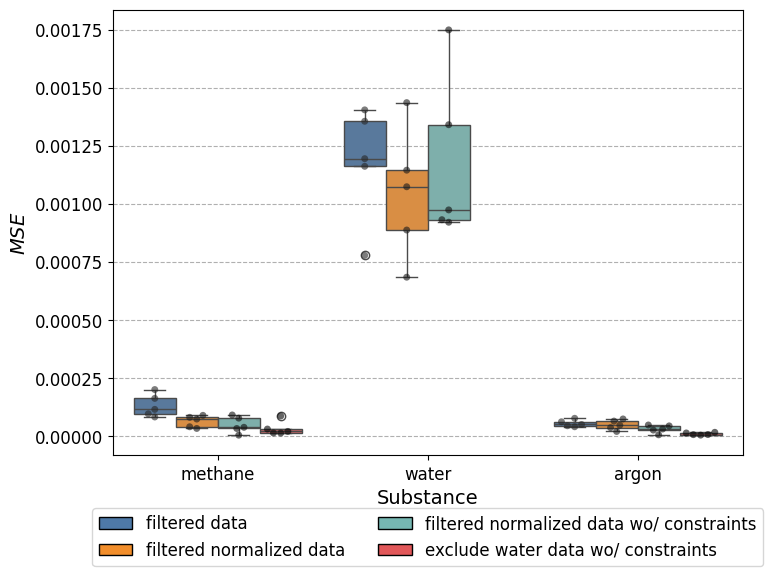

In [ ]:
dataset_colors = {
    'filtered data': '#4E79A7',
    'filtered normalized data': '#F28E2B',
    'filtered normalized data wo/ constraints': '#76B7B2',
    'exclude water data wo/ constraints': '#E15759',
    'water': '#59A14F',
}

# Define hatches for each substance
substance_hatches = {
    'water': '/',
    'methane': '\\',
    'argon': 'x'
}
df = MSE_s
# Create the boxplot with Seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df, x="Substance", y="Value", hue="Dataset", palette=dataset_colors)
ax = sns.swarmplot(data=df, x="Substance", y="Value", hue="Dataset", 
                   color='black', alpha=0.6, dodge=True)
color_legend = [Patch(facecolor=color, edgecolor='black', label=label)
                for label, color in dataset_colors.items()]
# put the legend outside the plot, under the x-axis
plt.legend(handles=color_legend, loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2)
plt.grid(axis='y', linestyle='--')
plt.xlabel("Substance")
plt.ylabel("$MSE$")
plt.tight_layout()
plt.show()

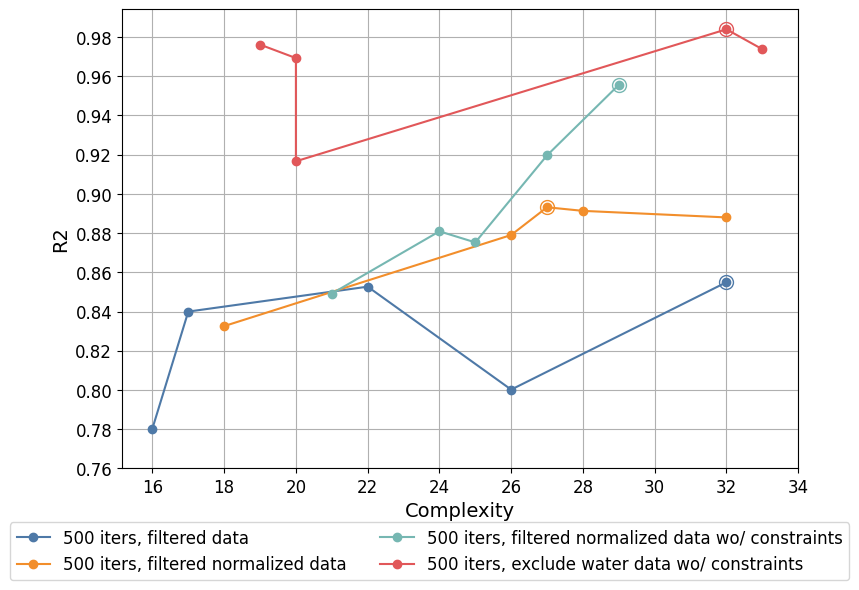

In [15]:

R2S = [R2_f, R2_fn_wc, R2_fn, R2_ew]
COMPLEXITIES = [COMPLEXITY_f, COMPLEXITY_fn_wc, COMPLEXITY_fn, COMPLEXITY_ew]
Y_PREDs = [Y_PRED_f, Y_PRED_fn_wc, Y_PRED_fn, Y_PRED_ew]
titles = ['filtered data', 'filtered normalized data', 'filtered normalized data wo/ constraints',
            'exclude water data wo/ constraints']
COLORS = ['#4E79A7', '#F28E2B', '#76B7B2','#E15759', '#FF0000', '#DC143C', '#B22222', '#8B0000', '#800000']

fig = plt.figure(figsize=(8, 6))
ax2 = fig.add_subplot(1, 1, 1)
for i in range(len(R2S)):
    data = {'R2': R2S[i], 'Complexity': COMPLEXITIES[i]}
    df = pd.DataFrame(data).sort_values(by='Complexity').reset_index(drop=True)
    ax2.plot(df['Complexity'], df['R2'], 'o-', color=COLORS[i], label=f'500 iters, {titles[i]}')
    max_r2 = df['R2'].max()
    max_complexity = df['Complexity'][df['R2'].idxmax()]
    ax2.plot(max_complexity, max_r2, 'o', color=COLORS[i], markersize=10, markerfacecolor='none')
ax2.set_xlabel('Complexity')
ax2.set_ylabel('R2')
ax2.set_xticks(np.arange(min(min(COMPLEXITIES)), max(max(COMPLEXITIES)) + 2, 2))
ax2.set_yticks(np.arange(round(min(min(R2S)) - 0.02, 2), round(max(max(R2S)) + 0.02, 2), 0.02))
ax2.grid()

handles, labels = ax2.get_legend_handles_labels()  # Get handles and labels from the pareto plot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=2, shadow=False)

# Adjust layout to fit legends and color bars
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom to make space for the legend
plt.show()



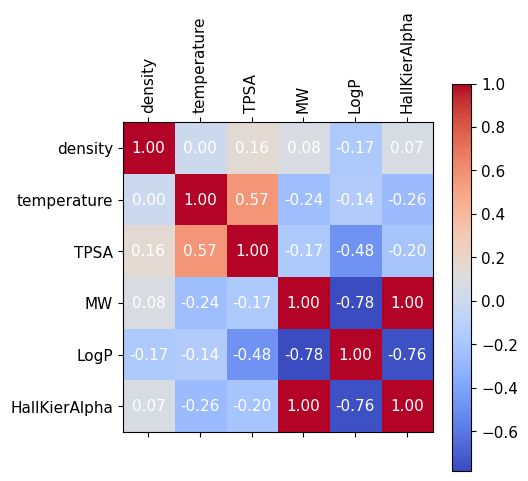

In [33]:
# calculate the person correlation coefficient of X
# plot the heatmap of the correlation matrix, show the correlation coefficient value in the heatmap
# fontsize
plt.rc('font', size=11)
corr = X.corr()
plt.figure(figsize=(5, 5))
plt.matshow(corr, fignum=1, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
for (i, j), val in np.ndenumerate(corr):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
plt.show()

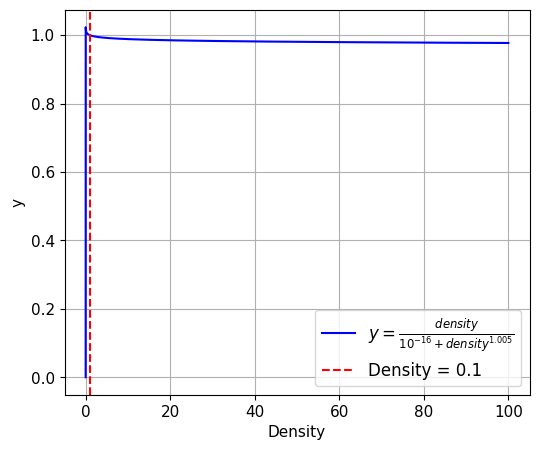

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define the density range
density = np.linspace(0, 100, 10000)  # Generate values from 0 to 10

# Define the custom weight function
weights = density / (10**(-16) + density**1.005)

# Plot the function
plt.figure(figsize=(6, 5))
plt.plot(density, weights, label=r'$y = \frac{density}{10^{-16} + density^{1.005}}$', color='blue')
plt.xlabel('Density')
plt.ylabel('y')
# plot x = 0.1
plt.axvline(x=1, color='red', linestyle='--', label='Density = 0.1')
plt.grid(True)
plt.legend(fontsize=12)
plt.show()



In [97]:
# print the equation and its complexity
best_model = model.get_best()
print(best_model)

complexity                                                                                               16
loss                                                                                               0.014068
score                                                                                               0.12741
equation         cube(-0.0067469096 * (0.2287218 * ((sqrt(density) * sin(-0.9328978 + MW)) + temperature)))
sympy_format                      3.67483085472592e-9*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**3
lambda_format    PySRFunction(X=>3.67483085472592e-9*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**3)
Name: 12, dtype: object


In [96]:
from sympy import symbols, limit, oo
density,temperature  = sp.symbols('density temperature')
new_eqaution = density*model.sympy()
res1=(new_eqaution).subs(density, 0)==0
restriction_2 = limit(equation, temperature, +oo).is_finite
print(res1,restriction_2)


True False


In [95]:
from sympy import diff
equation = model.sympy()
symbols_in_equation = equation.free_symbols
print("Symbols in the equation:", symbols_in_equation)
partials = {str(sym): diff(equation, sym) for sym in symbols_in_equation}
print("\nPartial derivatives:")
for sym, derivative in partials.items():
    print(f"∂/∂{sym}:", derivative)

Symbols in the equation: {temperature, density, MW}

Partial derivatives:
∂/∂temperature: -1.10244925641778e-8*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**2
∂/∂density: -5.51224628208888e-9*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**2*sin(MW - 0.9328978)/sqrt(density)
∂/∂MW: -1.10244925641778e-8*sqrt(density)*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**2*cos(MW - 0.9328978)


In [113]:
from restriction import Restriction
rr=Restriction(model).restriction_check()

Evaluating restrictions for 1.3974370738911e-10*(-0.0004653728*MW*density*(LogP + 0.12975854) - temperature)**3*log(MW)**3
Helmholtz Energy restrictions:
  Restriction 1: Satisfied
  Restriction 2: Not satisfied
Pressure restrictions:
  Restriction 1: Satisfied
  Restriction 2: Not satisfied
Internal Energy restrictions:
  Restriction 1: Satisfied
  Restriction 2: Not satisfied
Isochoric Heat Capacity restrictions:
  Restriction: Satisfied


In [115]:
fulfills = {}
if all(all(res) for res in rr.values()):
    fulfills[substance] = True
else:
    fulfills[substance] = False

In [160]:
import pandas as pd
data_a = pd.read_csv('data/processed_data/all_add_features_filtered_normalized.csv')
data= pd.read_csv('data/processed_data/exclude_water.csv')
data_n = pd.read_csv('data/processed_data/exclude_add_features_normalized.csv')
data_n1 = pd.read_csv('data/processed_data/exclude_water_add_features_normalized.csv')
data_fn = pd.read_csv('data/processed_data/exclude_add_features_filtered_normalized.csv')
data_water = pd.read_csv('data/processed_data/water_add_features_normalized.csv')

In [ ]:
data_n.describe().loc[['min', 'max']]


,density,temperature,TPSA,MW,delta_phi
min,1.0,1.0,0.0,16.043,-1.607006
max,100.0,100.0,0.0,39.948,-0.015087


In [159]:
data_n1.describe().loc[['min', 'max']]

,density,temperature,TPSA,MW,delta_phi
min,1.0,1.0,0.0,16.043,-1.607006
max,100.0,100.0,0.0,39.948,-0.015087


In [278]:
# check if there is NaN value in water data
data_water.isnull().sum()

density          0
temperature      0
TPSA             0
MW               0
LogP             0
HallKierAlpha    0
delta_phi        0
dtype: int64